In [1]:
# _*_ coding: utf-8 _*_

import os
import numpy as np
import tensorflow as tf
import cv2 as cv
from tqdm import tqdm
from keras.optimizers import SGD, RMSprop, Adam
from keras.applications import inception_v3, inception_resnet_v2, resnet50,xception,densenet
from keras.models import Model,load_model
from keras.layers import Dense, GlobalAveragePooling2D,Input,Dropout,Lambda, Concatenate
from keras.utils import to_categorical  
from keras import callbacks, regularizers
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import h5py
import keras.backend as K
import random, seaborn
import pandas as pd

/home/g674715911/anaconda3/envs/fastai/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
def train_valid_gen(shape):
    n = 25000
      
    X = np.zeros((n, shape[0],shape[1],3), dtype = np.uint8)
    y = np.zeros((n),dtype = np.uint8)
    for i in tqdm(range(n//2)):
        X[i] = cv.resize(cv.imread('train/cat.%d.jpg' % i), shape)
        y[i] = 0
        X[i+n//2] = cv.resize(cv.imread('train/dog.%d.jpg' % i), shape)
        #X[i] = tf.keras.preprocessing.image.random_shift(X[i],0.3,0.3,row_axis=0,col_axis=1,channel_axis=2,fill_mode='nearest',cval=0)
        #X[i+n//2] = tf.keras.preprocessing.image.random_shift(X[i+n//2],0.2,0.2,row_axis=0,col_axis=1,channel_axis=2,fill_mode='nearest',cval=0)    
        y[i+n//2] = 1
    return X, y



In [3]:
def test_gen(shape):
    n = 12500
    X_test = np.zeros((n, shape[0], shape[1], 3),dtype=np.uint8)
    for i in tqdm(range(1,n+1)):
        X_test[i-1] = cv.resize(cv.imread('test/%d.jpg' %i),shape)
    return X_test

## Input datas for ResNet50, VGG16 and DenseNet 

In [4]:
# Train set and validation set

shape_1 = (224,224)
X, Y = train_valid_gen(shape_1)

X_train, X_valid, y_train, y_valid = train_test_split(X, Y, test_size = 0.2, shuffle = True,random_state = 0)

#Test set
x_test = test_gen(shape_1)

100%|██████████| 12500/12500 [00:25<00:00, 498.53it/s]


In [12]:
#make sure the distribution of train set and valid set is similar
print(sum(y_train))
print(sum(y_valid))

9996
2504


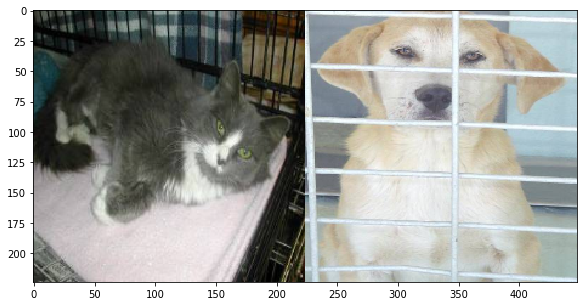

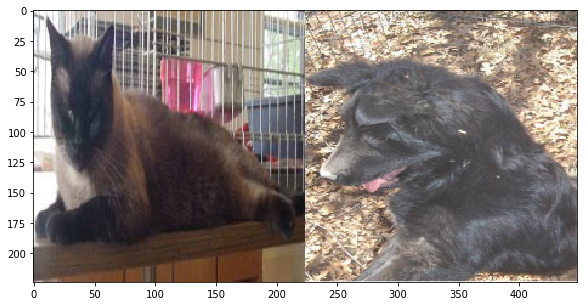

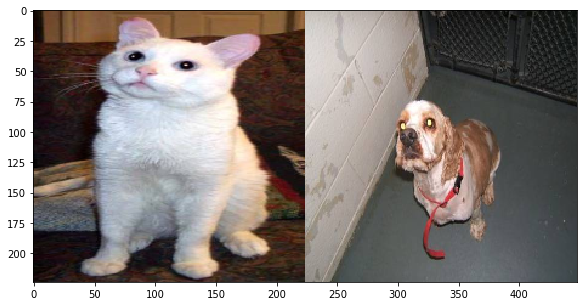

In [5]:
# Show some images
def show_cats_and_dogs(idx, X):
    cat = X[idx]
    dog = X[idx + 12500]
    pair = np.concatenate((cat, dog), axis=1)
    plt.figure(figsize=(10,5))
    plt.imshow(pair[:,:,::-1])
    plt.show()
    
for idx in range(0,3):
    np.random.seed(3)
    index = random.randint(0, 12499)
    show_cats_and_dogs(index, X)



## Outlier detection

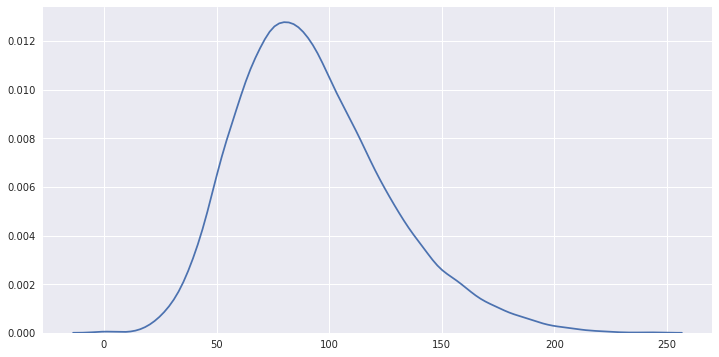

In [7]:
from scipy.stats import iqr

plt.figure(figsize=(12, 6))
iqr_x = X.reshape((25000, shape_1[0]*shape_1[1]*3))
iqr_iq = iqr(iqr_x, axis=1)
seaborn.set(color_codes=True)
seaborn.kdeplot(iqr_iq, cbar = True)

The len of outlier is: 16


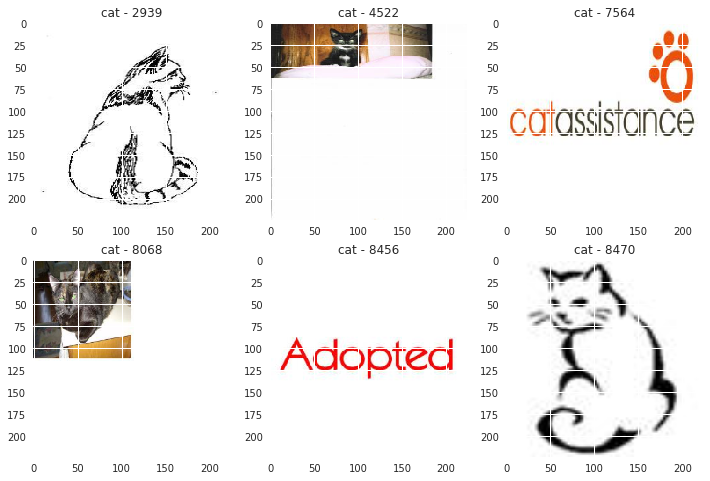

In [8]:
x_outlier =  np.where(iqr_iq < 10)[0]


plt.figure(figsize=(12, 8))
for i in range(6):
    pic_id = int(x_outlier[i])
    plt.subplot(2, 3, i+1)
    plt.imshow(X[pic_id][:,:,::-1])
    if Y[pic_id] == 0:
        plt.title('cat - ' + str(pic_id))
    else:
        plt.title('dog - ' + str(pic_id - 12500))
        
print ('The len of outlier is:', len(x_outlier))

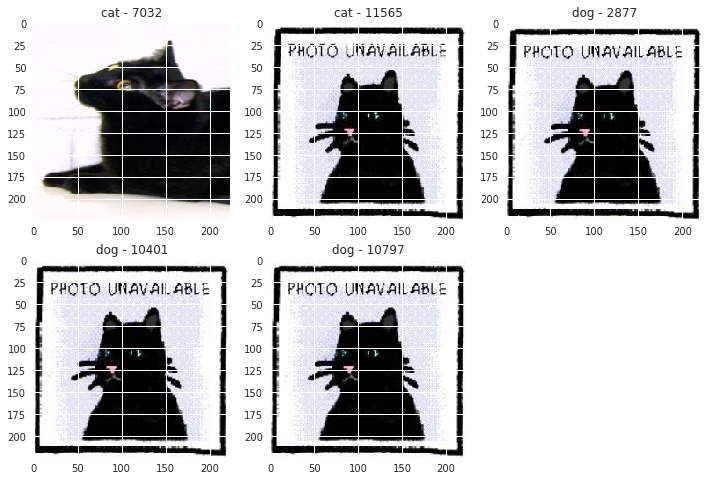

In [17]:
x_outlier =  np.where(iqr_iq > 235)[0]

plt.figure(figsize=(12, 8))
for i in range(5):
    pic_id = int(x_outlier[i])
    plt.subplot(2, 3, i+1)
    plt.imshow(X[pic_id][:,:,::-1])
    if Y[pic_id] == 0:
        plt.title('cat - ' + str(pic_id))
    else:
        plt.title('dog - ' + str(pic_id - 12500))

In [9]:
#clear the X and Y
del X, Y 

In [4]:
# Define the callbacks
## EarlyStopping: choose 'val_loss' as the monitor, and  5 as the number of epochs 
## with no improvement after which training will be stopped.
EarlyS = callbacks.EarlyStopping(monitor = 'val_loss', patience = 5, mode='auto')

## records events into a History object
class LossHistory():
    def on_train_begin(self, logs={}):
        self.losses = []
        self.val_losses = []
        
    def on_epoch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))

his = callbacks.History()

In [5]:
# create folders named 'models' and 'features'
def folder_create(folder_name):
    try:
        os.mkdir(folder_name)
    except OSError:
        pass
folder_create('./models')
folder_create('./features')

In [7]:
def extract_features(model, X_test):
    features = model.predict(X_test)
    np.save("./features/{0}_features.np".format(model.__name__),features)

In [5]:
def save_model(model):
    model.save("./models/{0}_model.h5".format(model.__name__))
    del model

In [6]:
def save_model_submission(model, x_test):
    predictions = model.predict(x_test, batch_size=128, verbose=1)
    
    
    model_name = model.__name__
    with open('submission_{}_5.csv'.format(model_name),'w') as f:
        f.write('id,label\n')
    with open('submission_{}_5.csv'.format(model_name),'a') as f:
        for i in tqdm(range(len(x_test))):
            pred = model.predict(x_test[i:i+1])
            pred = np.clip(pred, 0.005,0.995) # Clip (limit) the values in [0.005, 0.995]
            f.write('{},{}\n'.format(i+1,float(pred)))

#  Simple Models

## 1. ResNet50

In [24]:
# Preprosess the input tensor
input_x = Input((shape_1[0],shape_1[1],3))
input_x = Lambda(resnet50.preprocess_input)(input_x)
base_model_Res = resnet50.ResNet50(include_top=False, weights='imagenet', input_tensor=input_x)

# freeze all the layers
for layer in base_model_Res.layers:
    layer.trainable = False

# fine-tune the model    
x = base_model_Res.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.4)(x)
predictions = Dense(1,activation = 'sigmoid')(x)


model_x = Model(inputs = base_model_Res.input, outputs = predictions)
model_x.__name__ = 'resnet'
model_x.compile(optimizer='adam', loss = 'binary_crossentropy', metrics=['accuracy'])

model_x.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 224, 224, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           lambda_1[0][0]                   
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (

In [25]:
history_x = model_x.fit(X_train, y_train, batch_size = 256, epochs = 15, validation_data=(X_valid, y_valid),callbacks=[EarlyS,his])

Train on 20000 samples, validate on 5000 samples
Epoch 1/15
20000/20000 [==============================] - 88s 4ms/step - loss: 0.2509 - acc: 0.8936 - val_loss: 0.1023 - val_acc: 0.9630
Epoch 2/15
20000/20000 [==============================] - 75s 4ms/step - loss: 0.1097 - acc: 0.9596 - val_loss: 0.0915 - val_acc: 0.9660
Epoch 3/15
20000/20000 [==============================] - 75s 4ms/step - loss: 0.0917 - acc: 0.9668 - val_loss: 0.0935 - val_acc: 0.9666
Epoch 4/15
20000/20000 [==============================] - 75s 4ms/step - loss: 0.0826 - acc: 0.9688 - val_loss: 0.0992 - val_acc: 0.9638
Epoch 5/15
20000/20000 [==============================] - 75s 4ms/step - loss: 0.0768 - acc: 0.9709 - val_loss: 0.1049 - val_acc: 0.9632
Epoch 6/15
20000/20000 [==============================] - 75s 4ms/step - loss: 0.0732 - acc: 0.9715 - val_loss: 0.0848 - val_acc: 0.9716
Epoch 7/15
20000/20000 [==============================] - 75s 4ms/step - loss: 0.0691 - acc: 0.9743 - val_loss: 0.0707 - val_acc:

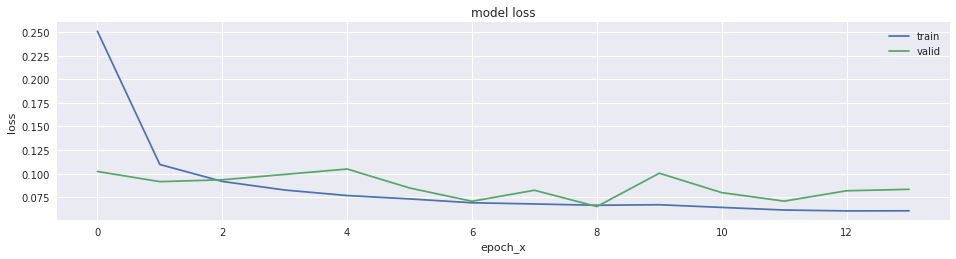

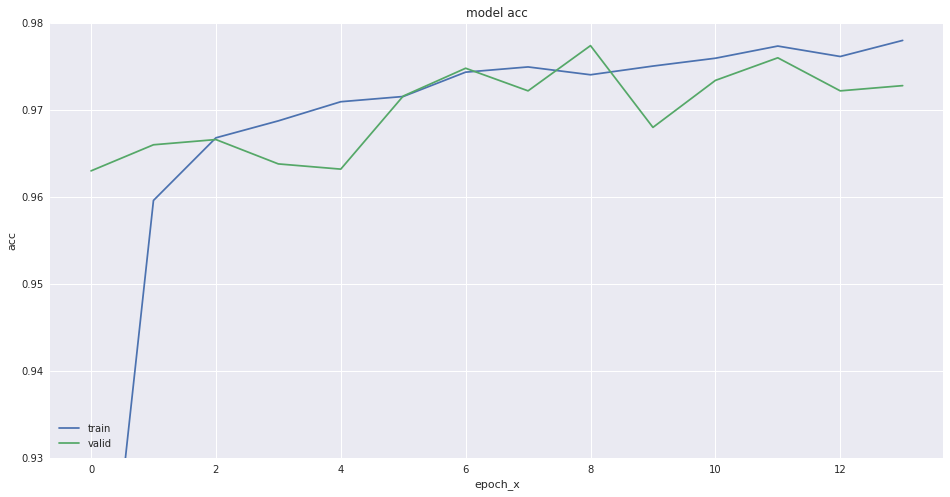

In [28]:
#show the 'val_loss' curve
plt.figure(figsize=(16,8)) 
plt.ylim((0.0, 0.05))
plt.subplot(212)  
plt.plot(history_x.history['loss'])  
plt.plot(history_x.history['val_loss'])
plt.title('model loss')  
plt.ylabel('loss')  
plt.xlabel('epoch_x')  
plt.legend(['train', 'valid'], loc='upper right')  
plt.show()  

#show the 'acc' curve 
plt.figure(figsize=(16,8)) 
plt.ylim((0.93, 0.98))
plt.plot(history_x.history['acc'])  
plt.plot(history_x.history['val_acc'])  
plt.title('model acc')  
plt.ylabel('acc')  
plt.xlabel('epoch_x')  
plt.legend(['train', 'valid'], loc='lower left')  
plt.show()  

In [29]:
# save model
#save_model(model_x)
#Predict the test set and save the submission
save_model_submission(model_x, x_test)
#extract features
extract_features(model_x, x_test)

12500/12500 [==============================] - 42s 3ms/step


100%|██████████| 12500/12500 [02:29<00:00, 83.57it/s]


## Input datas for InceptionV3, Xception and Inception_Resnet_v2

In [8]:
shape_2 = (299,299)
X, Y = train_valid_gen(shape_2)
x_test = test_gen(shape_2)

X_train, X_valid, y_train, y_valid = train_test_split(X, Y, test_size = 0.2, shuffle = True, random_state = 50)
# clear the input datas

del X, Y

100%|██████████| 12500/12500 [00:45<00:00, 276.51it/s]


In [10]:
#make sure the distribution of train set and valid set is similar
print (sum(y_train))
print (sum(y_valid))

9977
2523


## 2. InceptionV3

In [11]:
input_z = Input((shape_2[0],shape_2[1],3))
input_z = Lambda(inception_v3.preprocess_input)(input_z) 
base_model_Inception = inception_v3.InceptionV3(weights='imagenet', include_top = False, input_tensor = input_z)

z = base_model_Inception.output
z = GlobalAveragePooling2D()(z)
z = Dropout(0.5)(z)
#z = Dense(512, activation='relu')(z)

prediction = Dense(1, activation = 'sigmoid')(z)

#for layer in base_model_Inception.layers:
#    layer.trainable = False

model_z = Model(base_model_Inception.input, prediction)
sgd = SGD(lr=0.001, momentum=0.9, decay=1e-3)
#adam = Adam(lr=0.001)
model_z.compile(optimizer = sgd, loss = 'binary_crossentropy', metrics=['accuracy'])

model_z.__name__ = 'Inception_V3'
model_z.summary()



__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 299, 299, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 149, 149, 32) 864         lambda_1[0][0]                   
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 149, 149, 32) 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation

In [12]:
history_z = model_z.fit(X_train, y_train, batch_size = 64, epochs = 20, validation_data=(X_valid, y_valid),callbacks=[EarlyS, his])

Train on 20000 samples, validate on 5000 samples
Epoch 1/20
20000/20000 [==============================] - 268s 13ms/step - loss: 0.1081 - acc: 0.9579 - val_loss: 0.0347 - val_acc: 0.9898
Epoch 2/20
20000/20000 [==============================] - 248s 12ms/step - loss: 0.0283 - acc: 0.9907 - val_loss: 0.0306 - val_acc: 0.9902
Epoch 3/20
20000/20000 [==============================] - 248s 12ms/step - loss: 0.0161 - acc: 0.9950 - val_loss: 0.0289 - val_acc: 0.9916
Epoch 4/20
20000/20000 [==============================] - 248s 12ms/step - loss: 0.0119 - acc: 0.9963 - val_loss: 0.0290 - val_acc: 0.9920
Epoch 5/20
20000/20000 [==============================] - 248s 12ms/step - loss: 0.0079 - acc: 0.9986 - val_loss: 0.0300 - val_acc: 0.9916
Epoch 6/20
20000/20000 [==============================] - 248s 12ms/step - loss: 0.0080 - acc: 0.9979 - val_loss: 0.0301 - val_acc: 0.9914
Epoch 7/20
20000/20000 [==============================] - 248s 12ms/step - loss: 0.0064 - acc: 0.9986 - val_loss: 0.0

In [13]:
#save model
#save_model(model_z)
#Predict the test set and save the submission
save_model_submission(model_z, x_test)
#extract features
extract_features(model_z,  x_test)

12500/12500 [==============================] - 67s 5ms/step


100%|██████████| 12500/12500 [04:20<00:00, 47.93it/s]


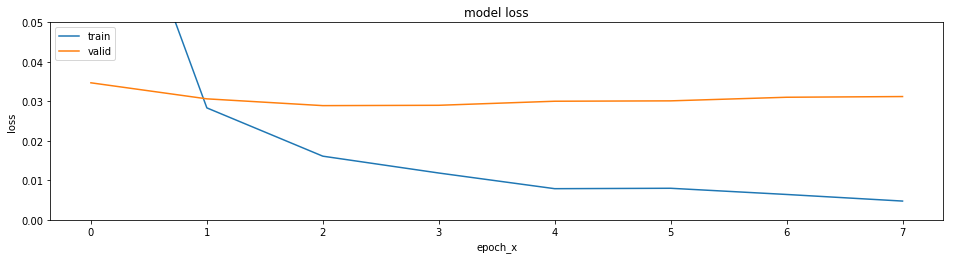

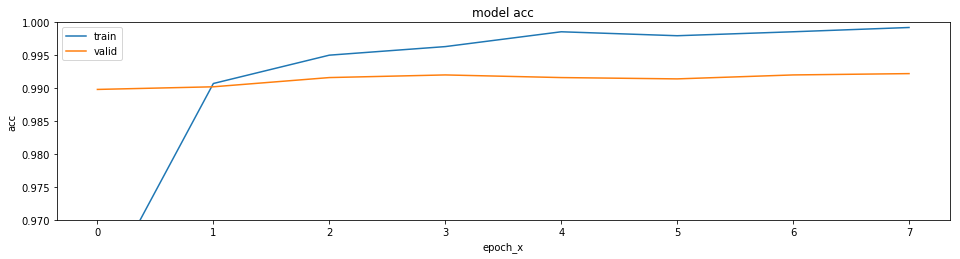

In [14]:
plt.figure(figsize=(16,8)) 
plt.subplot(212)  
plt.plot(history_z.history['loss'])  
plt.plot(history_z.history['val_loss']) 
plt.ylim((0.0, 0.05))
plt.title('model loss')  
plt.ylabel('loss')  
plt.xlabel('epoch_x')  
plt.legend(['train', 'valid'], loc='upper left')  
plt.show()  

plt.figure(figsize=(16,8)) 
plt.subplot(212)  
plt.plot(history_z.history['acc'])  
plt.plot(history_z.history['val_acc'])  
plt.ylim((0.97, 1.00))
plt.title('model acc')  
plt.ylabel('acc')  
plt.xlabel('epoch_x')  
plt.legend(['train', 'valid'], loc='upper left')  
plt.show()

## 3. Xception

In [11]:
input_w = Input((shape_2[0],shape_2[1],3))
input_w = Lambda(xception.preprocess_input)(input_w) 
base_model_xception = xception.Xception(weights='imagenet', include_top = False, input_tensor = input_w)

w = base_model_xception.output
w = GlobalAveragePooling2D()(w)
w = Dropout(0.5)(w)
prediction = Dense(1, activation = 'sigmoid')(w)

model_w = Model(base_model_xception.input, prediction)
sgd = SGD(lr=0.001, momentum=0.9, decay=1e-3)
model_w.compile(optimizer = sgd, loss = 'binary_crossentropy', metrics=['accuracy'])
model_w.__name__ = 'Xception'
model_w.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 299, 299, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 149, 149, 32) 864         lambda_1[0][0]                   
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 149, 149, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_con

In [12]:
history_w = model_w.fit(X_train, y_train, batch_size = 32, epochs = 10,validation_data=(X_valid, y_valid),callbacks=[EarlyS, his])

Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 524s 26ms/step - loss: 0.1390 - acc: 0.9602 - val_loss: 0.0390 - val_acc: 0.9906
Epoch 2/10
20000/20000 [==============================] - 509s 25ms/step - loss: 0.0440 - acc: 0.9873 - val_loss: 0.0288 - val_acc: 0.9922
Epoch 3/10
20000/20000 [==============================] - 509s 25ms/step - loss: 0.0333 - acc: 0.9898 - val_loss: 0.0252 - val_acc: 0.9918
Epoch 4/10
20000/20000 [==============================] - 509s 25ms/step - loss: 0.0261 - acc: 0.9924 - val_loss: 0.0241 - val_acc: 0.9922
Epoch 5/10
20000/20000 [==============================] - 509s 25ms/step - loss: 0.0243 - acc: 0.9927 - val_loss: 0.0229 - val_acc: 0.9926
Epoch 6/10
20000/20000 [==============================] - 511s 26ms/step - loss: 0.0209 - acc: 0.9939 - val_loss: 0.0223 - val_acc: 0.9930
Epoch 7/10
20000/20000 [==============================] - 519s 26ms/step - loss: 0.0194 - acc: 0.9940 - val_loss: 0.0

In [ ]:
#save model
#save_model(model_w)
#Predict the test set and save the submission
save_model_submission(model_w, x_test)
#extract features
extract_features(model_w, x_test)

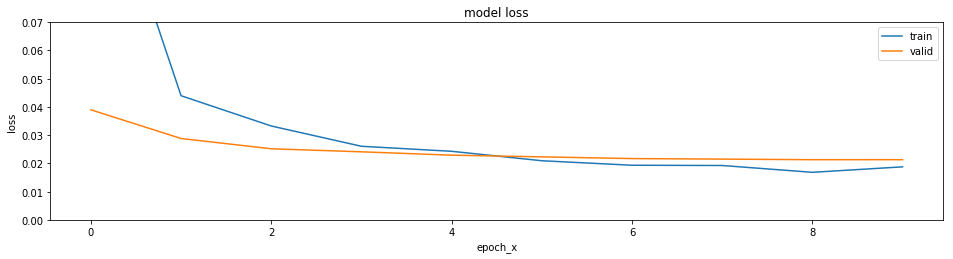

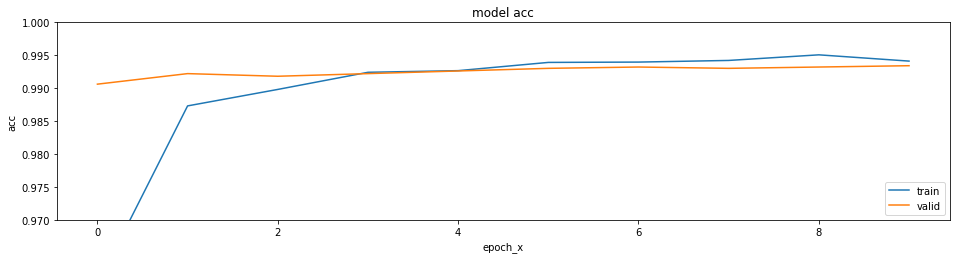

In [14]:
plt.figure(figsize=(16,8)) 
plt.subplot(212)  
plt.plot(history_w.history['loss'])  
plt.plot(history_w.history['val_loss']) 
plt.ylim((0.0, 0.07)) 
plt.title('model loss')  
plt.ylabel('loss')  
plt.xlabel('epoch_x')  
plt.legend(['train', 'valid'], loc='upper right')  
plt.show()  

plt.figure(figsize=(16,8)) 
plt.subplot(212)  
plt.plot(history_w.history['acc'])  
plt.plot(history_w.history['val_acc'])  
plt.ylim((0.97, 1.00))
plt.title('model acc')  
plt.ylabel('acc')  
plt.xlabel('epoch_x')  
plt.legend(['train', 'valid'], loc='lower right')  
plt.show()  

## 4. Inception_Resnet_v2

In [13]:
input_y = Input((shape_2[0],shape_2[1],3))
input_y = Lambda(inception_resnet_v2.preprocess_input)(input_y) 
base_model_inception_resnet_v2 = inception_resnet_v2.InceptionResNetV2(weights='imagenet', include_top = False, input_tensor = input_y)

y = base_model_inception_resnet_v2.output
y = GlobalAveragePooling2D()(y)
#y = Dropout(0.2)(y)
prediction = Dense(1, activation = 'sigmoid')(y)

model_y = Model(base_model_inception_resnet_v2.input, prediction)
sgd = SGD(lr=0.001, momentum=0.9, decay=1e-3)
model_y.compile(optimizer = sgd, loss = 'binary_crossentropy', metrics=['accuracy'])

model_y.__name__ = 'inception_resnet_v2'
model_y.summary()


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
lambda_3 (Lambda)               (None, 299, 299, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_407 (Conv2D)             (None, 149, 149, 32) 864         lambda_3[0][0]                   
__________________________________________________________________________________________________
batch_normalization_407 (BatchN (None, 149, 149, 32) 96          conv2d_407[0][0]                 
__________________________________________________________________________________________________
activation

In [14]:
history_y = model_y.fit(X_train, y_train, batch_size = 32, epochs = 10,validation_data=(X_valid, y_valid),callbacks=[EarlyS, his])

Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 501s 25ms/step - loss: 0.0897 - acc: 0.9722 - val_loss: 0.0287 - val_acc: 0.9904
Epoch 2/10
20000/20000 [==============================] - 464s 23ms/step - loss: 0.0276 - acc: 0.9899 - val_loss: 0.0238 - val_acc: 0.9930
Epoch 3/10
20000/20000 [==============================] - 463s 23ms/step - loss: 0.0195 - acc: 0.9935 - val_loss: 0.0232 - val_acc: 0.9930
Epoch 4/10
20000/20000 [==============================] - 462s 23ms/step - loss: 0.0155 - acc: 0.9950 - val_loss: 0.0225 - val_acc: 0.9932
Epoch 5/10
20000/20000 [==============================] - 463s 23ms/step - loss: 0.0139 - acc: 0.9955 - val_loss: 0.0223 - val_acc: 0.9934
Epoch 6/10
20000/20000 [==============================] - 463s 23ms/step - loss: 0.0111 - acc: 0.9970 - val_loss: 0.0225 - val_acc: 0.9936
Epoch 7/10
20000/20000 [==============================] - 463s 23ms/step - loss: 0.0109 - acc: 0.9970 - val_loss: 0.0

In [15]:
#save model
#save_model(model_y)
#Predict the test set and save the submission
save_model_submission(model_y, x_test)
#extract features
extract_features(model_y,  x_test)

12500/12500 [==============================] - 118s 9ms/step


100%|██████████| 12500/12500 [08:30<00:00, 24.48it/s]


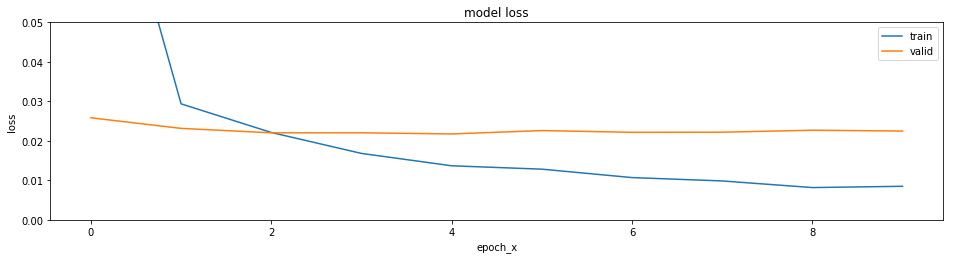

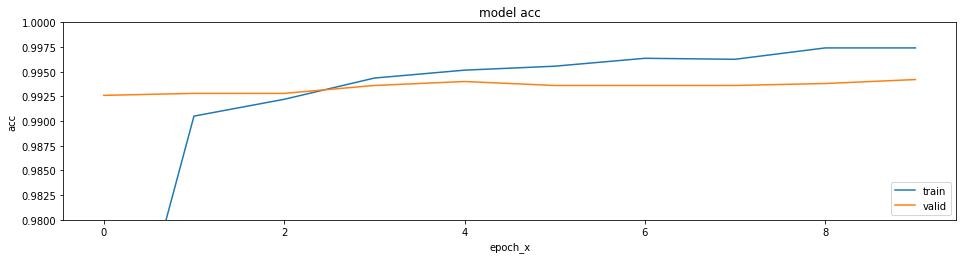

In [19]:
plt.figure(figsize=(16,8)) 
plt.subplot(212)  
plt.plot(history_y.history['loss'])  
plt.plot(history_y.history['val_loss']) 
plt.ylim((0.0, 0.05)) 
plt.title('model loss')  
plt.ylabel('loss')  
plt.xlabel('epoch_x')  
plt.legend(['train', 'valid'], loc='upper right')  
plt.show()  

plt.figure(figsize=(16,8)) 
plt.subplot(212)  
plt.plot(history_y.history['acc'])  
plt.plot(history_y.history['val_acc'])  
plt.ylim((0.98, 1.00))
plt.title('model acc')  
plt.ylabel('acc')  
plt.xlabel('epoch_x')  
plt.legend(['train', 'valid'], loc='lower right')  
plt.show()  

# InceptionV3, Xception and Inception_Resnet_v2 Stacking

In [ ]:
input_wyz = Input((shape_2[0],shape_2[1],3))
input_wyz = Lambda(inception_resnet_v2.preprocess_input)(input_wyz)

model_xcep = xception.Xception(weights='imagenet', include_top = False, input_tensor = input_wyz)
model_xcep = GlobalAveragePooling2D()(model_xcep.output)


model_incep = inception_v3.InceptionV3(weights='imagenet', include_top = False, input_tensor = input_wyz)
model_incep = GlobalAveragePooling2D()(model_incep.output)

model_incep_resnet = inception_resnet_v2.InceptionResNetV2(weights='imagenet', include_top = False, input_tensor = input_wyz)
model_incep_resnet = GlobalAveragePooling2D()(model_incep_resnet.output)

wyz = Concatenate()([model_xcep, model_incep, model_incep_resnet]) 

wyz = Dropout(0.3)(wyz)
prediction = Dense(1, activation = 'sigmoid')(wyz)

model_wyz = Model([model_xcep.input, model_incep.input, model_incep_resnet.input], prediction)
sgd = SGD(lr=0.001, momentum=0.9, decay=1e-3)
model_wyz.compile(optimizer = sgd, loss = 'binary_crossentropy', metrics=['accuracy'])

model_wyz.__name__ = 'Stacking_models'
model_wyz.summary()


In [11]:
history_wyz = model_wyz.fit(X_train, y_train, batch_size = 16, epochs = 20, validation_data=(X_valid, y_valid),callbacks=[EarlyS, his])

Train on 20000 samples, validate on 5000 samples
Epoch 1/20
20000/20000 [==============================] - 1306s 65ms/step - loss: 0.0764 - acc: 0.9711 - val_loss: 0.0265 - val_acc: 0.9912
Epoch 2/20
20000/20000 [==============================] - 1273s 64ms/step - loss: 0.0327 - acc: 0.9888 - val_loss: 0.0237 - val_acc: 0.9924
Epoch 3/20
20000/20000 [==============================] - 1273s 64ms/step - loss: 0.0238 - acc: 0.9925 - val_loss: 0.0235 - val_acc: 0.9924
Epoch 4/20
20000/20000 [==============================] - 1272s 64ms/step - loss: 0.0185 - acc: 0.9940 - val_loss: 0.0241 - val_acc: 0.9922
Epoch 5/20
20000/20000 [==============================] - 1273s 64ms/step - loss: 0.0151 - acc: 0.9956 - val_loss: 0.0237 - val_acc: 0.9926
Epoch 6/20
20000/20000 [==============================] - 1273s 64ms/step - loss: 0.0144 - acc: 0.9960 - val_loss: 0.0241 - val_acc: 0.9924
Epoch 7/20
20000/20000 [==============================] - 1273s 64ms/step - loss: 0.0120 - acc: 0.9970 - val_lo

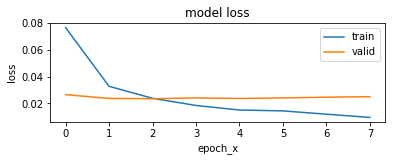

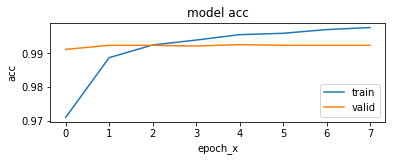

In [12]:
plt.figure(figsize=(16,8)) 
plt.ylim((0.0, 0.05)) 
plt.subplot(212)  
plt.plot(history_wyz.history['loss'])  
plt.plot(history_wyz.history['val_loss']) 
plt.title('model loss')  
plt.ylabel('loss')  
plt.xlabel('epoch_x')  
plt.legend(['train', 'valid'], loc='upper right')  
plt.show()  

plt.figure(figsize=(16,8)) 
plt.ylim((0.98, 1.00))
plt.subplot(212)  
plt.plot(history_wyz.history['acc'])  
plt.plot(history_wyz.history['val_acc'])  
plt.title('model acc')  
plt.ylabel('acc')  
plt.xlabel('epoch_x')  
plt.legend(['train', 'valid'], loc='lower right')  
plt.show()  

In [18]:
##Predict the test set and save the submission
save_model_submission(model_wyz, x_test)

12500/12500 [==============================] - 225s 18ms/step


100%|██████████| 12500/12500 [14:32<00:00, 14.32it/s]


In [15]:
## Load Features
'''
inception_features = np.load('./features/Inception_V3_features.np.npy')
xception_features = np.load('./features/Xception_features.np.npy')
inceRes_features = np.load('./features/inception_resnet_v2_features.np.npy')

features_test = np.concatenate([inception_features, xception_features, inceRes_features], axis=-1)
'''

## Visualizing results

In [6]:
test_set = pd.read_csv('submission_Stacking_models.csv')
test_set.head()

,id,label
0,1,0.995
1,2,0.995
2,3,0.995
3,4,0.995
4,5,0.005


In [16]:
# print the len of dataframe whose labels are less than 0.53 and more than 0.47
print('the len of test_y is:', len(test_set[(test_set['label'] < 0.60) & (test_set['label'] > 0.40)]))

the len of test_y is: 33


In [15]:
# extract the id whose labels are less than 0.53 and more than 0.47
test_y = test_set[(test_set['label'] < 0.53) & (test_set['label'] > 0.47)]
print(test_y)

          id     label
3683    3684  0.526501
3921    3922  0.502555
4237    4238  0.472075
5668    5669  0.503780
7705    7706  0.474131
8805    8806  0.526946
10851  10852  0.505247
11028  11029  0.519238


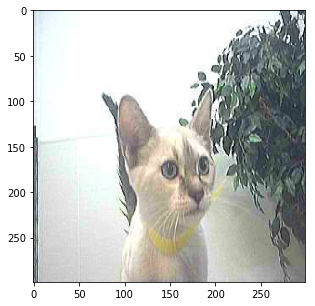

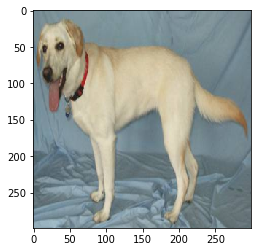

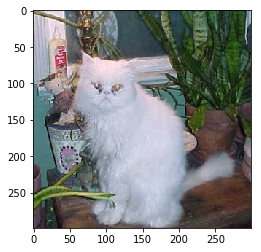

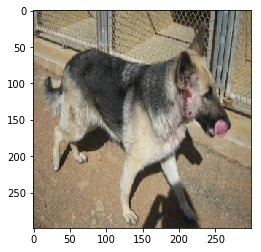

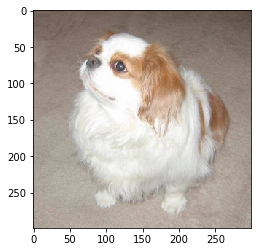

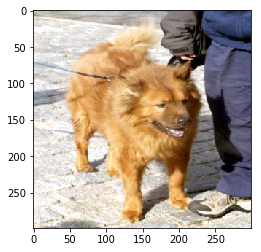

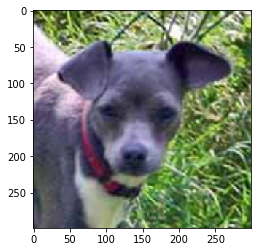

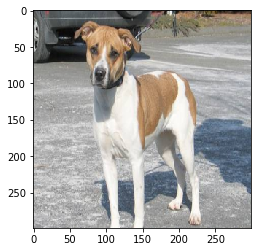

In [52]:
plt.figure(figsize=(10, 5))
for i in test_y['id']:
    plt.imshow(x_test[i][:,:,::-1])
    plt.show()